In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def get_mask_imgs(img_path):
    mask_imgs = []
    for img in os.listdir(img_path):
        if img.split('.')[-1] == 'png':
            mask_imgs.append(img_path+"/"+img)
    return mask_imgs

def read_imgs(mask_path):
    mask_imgs = get_mask_imgs(mask_path)
    # print(mask_imgs)
    masks = []
    for img in mask_imgs:
        mask = cv2.imread(img, 0)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        ret, bw_img = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
        # print(bw_img.shape)
        # plt.imshow(mask)
        masks.append(bw_img)
    return masks

def find_rectangle_manually(given_masks):
    rectangles = []
    for mask in given_masks:
        mask = np.array(mask)
        gray_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        # print(*gray_mask[400])
        row_ind = []
        for i in range(gray_mask.shape[0]):
            inds = np.where(gray_mask[i] == 255)[0]
            if inds.size != 0:
                row_ind.append(i)
        top, bottom = row_ind[0], row_ind[-1]

        col_ind = []
        for i in range(gray_mask.shape[1]):
            inds = np.where(gray_mask[:, i] == 255)[0]
            if inds.size != 0:
                col_ind.append(i)
        left, right = col_ind[0], col_ind[-1]

        rectangles.append([
            [left, top],
            [right, top],
            [right, bottom],
            [left, bottom]
        ])
    return rectangles

In [3]:
pip install rdp

Note: you may need to restart the kernel to use updated packages.


In [6]:
# erode = cv2.erode(mask, (5, 5), iterations = 10)
# plt.imshow(erode)

# morph = cv2.morphologyEx(mask, cv2.MORPH_OPEN, (5, 5), iterations=10)
# plt.imshow(morph)

# dil = cv2.dilate(erode, (5,5), iterations = 10)
# plt.imshow(dil)

In [4]:
from rdp import rdp
def find_peak_points(mask):
    msk = mask.copy()
    edge=cv2.Canny(msk, 30, 20)
    contours, hierarchy = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    ## separating the mask outline from all other unwanted contours
    outline = []
    for i in contours:
        # print(len(i))
        if i.shape[0] > 100:
            outline.extend(i)
    # print(outline.shape)

    msk = cv2.drawContours(msk, outline, -1, (0, 255, 0), 3)
    ## finding the peak points using the Douglas-Peucker algorithm
    pp=rdp(outline, epsilon=75)
    for i in pp:
        msk = cv2.circle(msk, i[0], 5, (0, 0, 255), -1)
    plt.imshow(msk)
    return np.array(pp)

def pick_peak_pts(mask, pp):
    rect = find_rectangle_manually([mask])[0]
    new_rect = []
    for p1 in rect:
        pt_dist = []
        for p2 in pp:
            dist = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
            pt_dist = np.append(pt_dist, dist)
        # print(pt_dist)
        new_rect.append(pp[np.argmin(pt_dist)])

    tmp = mask.copy()
    for i in pp:
        tmp = cv2.circle(tmp, i, 10, (0, 0, 255), -1)
    for i in range(4):
        tmp = cv2.circle(tmp, rect[i], 8, (255, 0, 0), -1)
        tmp = cv2.circle(tmp, new_rect[i], 8, (0, 255, 0), -1)
    plt.imshow(tmp)

    return rect, np.array(new_rect)

In [5]:
USER_IMG = 'kitchen'

all_mask_paths = "../inputs/masks/{}".format(USER_IMG)
all_masks = read_imgs(all_mask_paths)
print(len(all_masks))

3


In [33]:
peak_pts, new_rectangles, rectangles, peak_points_for_masks = [], [], [], []

[[ 895 1030]
 [ 884 1135]
 [ 938 1011]
 [1023 1134]
 [ 939 1011]
 [1209  859]
 [ 496  838]
 [   0  982]
 [ 496  838]
 [ 499 1025]
 [ 653 1135]
 [   0 1136]
 [ 654 1135]
 [ 498 1023]
 [ 497  839]
 [1306  772]
 [1189 1003]
 [1099  914]
 [1082 1089]
 [ 980  989]
 [1042 1134]
 [1599 1136]
 [1041 1132]
 [ 979  991]
 [1082 1089]
 [1098  916]
 [1190 1003]
 [1304  773]
 [1599  821]
 [1307  772]]


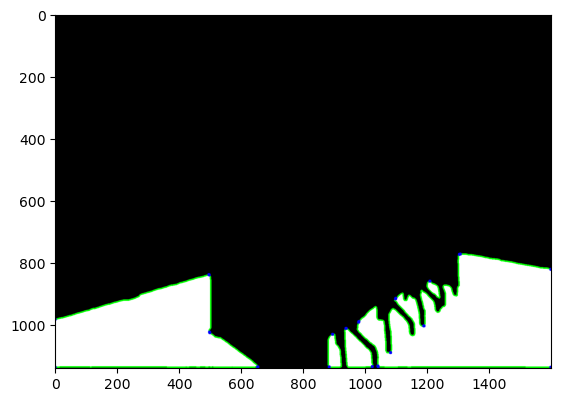

In [34]:
mask = all_masks[0]
peak_pts = find_peak_points(mask).reshape([-1, 2])
peak_points_for_masks.append(peak_pts)
print((peak_pts))

array([[   0,  982],
       [1599,  821],
       [1599, 1136],
       [   0, 1136]])

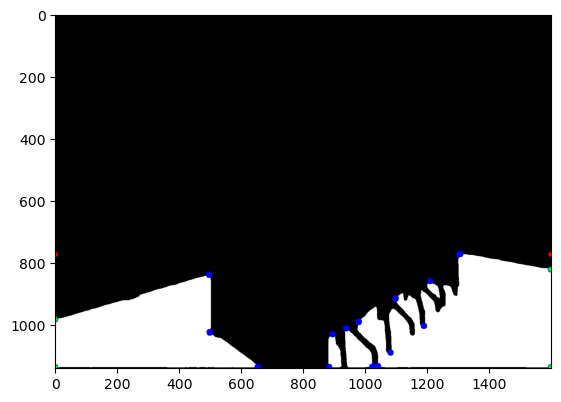

In [35]:
rect, new_rect = pick_peak_pts(mask, peak_pts)
rectangles.append(rect)
new_rectangles.append(new_rect)
new_rect

In [36]:
def isClose(pt, seed):
    # if abs(pt[0]-seed[0]) >= 275 and abs(pt[1]-seed[1]) >= 275:
    #     return False
    distance = ((pt[0] - seed[0]) ** 2 + (pt[1] - seed[1]) ** 2) ** 0.5
    if distance > 75:
      # print(distance)
      # if abs(pt[0] - 630) < 15:
      #   print(distance, pt, seed)
      return False
    # print(distance, pt, seed)
    return True

Method 2

In [38]:
linkedlist = []
for i in range(len(peak_points_for_masks)):
  for pt in peak_points_for_masks[i]:
    # if i ==0:
      # print(str(pt)+" first mask points")
    # if pt[0] == 626 and pt[1] == 775:
      # print(linkedlist)
      # print()
      # print("----------------------------")
      # print()
    flag = True
    for sublist in linkedlist:
      if isClose(pt, sublist[0][0]):
        sublist.append([pt, i])
        flag = False
    if flag:
      linkedlist.append([[pt,i]])

twoMaskIntersection, threeMaskIntersection = [], []

for sublist in linkedlist:
  # print(sublist)
  c, uniqueIndex, seed = 0, [], sublist[0][0]
  for entry in sublist:
    if entry[1] not in uniqueIndex:
      uniqueIndex.append(entry[1])
      c += 1
  if c == 2:
    twoMaskIntersection.append([seed,uniqueIndex])
  if c == 3:
    threeMaskIntersection.append([seed,uniqueIndex])
# print('####################################')

if len(all_masks) >= 3:
  for pt in twoMaskIntersection:
    print('Point : '+ str(pt[0]) + ' Intersecting masks are : ' + str(pt[1]))
  print('----------------------------------')
  print("The fixed points are:")
  for pt in threeMaskIntersection:
    print('Point : '+ str(pt[0]) + ' Intersecting masks are : ' + str(pt[1]))
else:
  print("The fixed points are:")
  for pt in twoMaskIntersection:
    print('Point : '+ str(pt[0]) + ' Intersecting masks are : ' + str(pt[1]))


----------------------------------
The fixed points are:


Method 1

In [21]:
corner_pts, di, li2 = [], {}, []
for i in range(len(peak_points_for_masks)):
  # if i == 0:
  #   for pt in peak_points_for_masks[i]:
  #     flag = True
  #     for pt1 in di.keys():
  #       if i in di[pt1][3]:
  #         continue
  #       if isClose(pt, di[pt1][2]):
  #         flag = False
  #         di[pt1][2][0] = di[pt1][1][0] + pt[0] // 2
  #         di[pt1][2][1] = di[pt1][1][1] + pt[1] // 2
  #         di[pt1][1][0] = di[pt1][2][0]
  #         di[pt1][1][1] = di[pt1][2][1]
  #     # print(pt)
  #     if flag:
  #       di[tuple(pt)] = [1, pt, pt, [i]]
  # else:
  #   for pt in peak_points_for_masks[i]:
  #     flag = True
  #     for pt1 in di.keys():
  #       if i in di[pt1][3]:
  #         continue
  #       if isClose(pt, di[pt1][2]):
  #         flag = False
  #         di[pt1][0] += 1
  #         di[pt1][1][0] += pt[0]
  #         di[pt1][1][1] += pt[1]
  #         di[pt1][2][0] = di[pt1][1][0] // di[pt1][0]
  #         di[pt1][2][1] = di[pt1][1][1] // di[pt1][0]
  #         di[pt1][3].append(i)
  #     if flag:
  #       di[tuple(pt)] = [1, pt, pt, [i]]
  for pt in peak_points_for_masks[i]:
    flag, fl = True, True
    for pt1 in di.keys():
      if i in di[pt1][3]:
        fl = False
        continue
        if i == 2:
          print('ttttttt', pt, di[pt1][2],isClose(pt, di[pt1][2]))
      if isClose(pt, di[pt1][2]):
        flag = False
        di[pt1][0] += 1
        di[pt1][1][0] += pt[0]
        di[pt1][1][1] += pt[1]
        di[pt1][2][0] = di[pt1][1][0] // di[pt1][0]
        di[pt1][2][1] = di[pt1][1][1] // di[pt1][0]
        di[pt1][3].append(i)
        break
    if flag:
      if fl:
        di[tuple(pt)] = [1, pt, pt, [i]]
      else:
        if isClose(pt, di[pt1][2]):
          flag = False
          di[pt1][1][0] += pt[0]
          di[pt1][1][1] += pt[1]
          di[pt1][2][0] = di[pt1][1][0] // 2
          di[pt1][2][1] = di[pt1][1][1] // 2
          di[pt1][1][0] += di[pt1][2][0]
          di[pt1][1][1] += di[pt1][2][1]
print(len(di.keys()))
for key in di.keys():
  if di[key][0] > 1:
    li2.append(di[key][2])
    print(di[key][2], key, di[key][3])


3


In [22]:
def isSame(pt, pt1):
  if pt[0] != pt1[0] or pt[1] != pt1[1]:
    return False
  return True

In [23]:
li1 = []
for i in range(len(new_rectangles)):
  for pt in new_rectangles[i]:
    print(i, str(pt) + '  - 1')
    for p in li2:
      if isClose(pt, p):
        flag = True
        for pt1 in li1:
          if isSame(pt, pt1):
            flag = False
            break
        if flag:
          li1.append(pt)
          print(i, pt, p)


0 [  0 375]  - 1
0 [683 421]  - 1
0 [668 579]  - 1
0 [ 39 641]  - 1
1 [  0 375]  - 1
1 [683 421]  - 1
1 [668 579]  - 1
1 [ 39 641]  - 1
2 [ 0 57]  - 1
2 [869 188]  - 1
2 [941 377]  - 1
2 [ 31 640]  - 1


In [24]:
li1 = []
for i in range(len(peak_points_for_masks)):
  for pt in peak_points_for_masks[i]:
    # print(i, str(pt) + '  - 1')
    for p in li2:
      if isClose(pt, p):
        flag = True
        for pt1 in li1:
          if isClose(pt, pt1):
            flag = False
            break
        if flag:
          # print(li1)
          li1.append(p)
          print(i, pt, p)